# Modelling the AI consumption estimation tool

# 1. Setup

Standard imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Reading our data

In [ ]:
register = pd.read_csv("register.csv")
rooms = pd.read_csv("rooms.csv")

# 2. Feature Engineering

- Summing the amount column for the same room and the same month to get the total energy consumed in a month
- Left Joining register and rooms dataframes

In [ ]:
grouped = register.groupby(["legal_entity", "service_category", "room_id", "month"])["amount"].sum().reset_index()
joined = pd.merge(grouped, rooms, on="room_id", how="left")
joined.head(3)

,legal_entity,service_category,room_id,month,amount,building_id,room_area,build_year,building_floors,building_type,building_func,x_coord,y_coord
0,False,Dvinarė kaina,005f6379f5dc0e1,2018-11-01,0.74,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
1,False,Dvinarė kaina,005f6379f5dc0e1,2018-12-01,0.74,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
2,False,Dvinarė kaina,005f6379f5dc0e1,2019-01-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0


- Dropping useless columns like room_id, building_id, because they logically don't have an impact on the target column, or we don't want to rely on them for a prediction.
- Converting datetime columns to numerical columns

In [ ]:
dropped = joined.drop(["room_id", "building_id", "building_type"], axis=1)

dropped["build_year"] = pd.to_datetime(dropped["build_year"])
dropped["build_year"] = dropped["build_year"].dt.year

dropped["month"] = pd.to_datetime(dropped["month"])
dropped["month"] = dropped["month"].dt.month

dropped.head()

,legal_entity,service_category,month,amount,room_area,build_year,building_floors,building_func,x_coord,y_coord
0,False,Dvinarė kaina,11,0.74,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
1,False,Dvinarė kaina,12,0.74,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
2,False,Dvinarė kaina,1,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
3,False,Dvinarė kaina,2,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
4,False,Dvinarė kaina,3,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0


Selecting rows only for a certain category

In [ ]:
filtered = dropped[dropped["service_category"] == "Šiluma"]
filtered.drop(['service_category'], axis=1, inplace=True)
len(filtered), len(dropped)
filtered.head()

<ipython-input-7-4393f81aa065>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.drop(['service_category'], axis=1, inplace=True)


,legal_entity,month,amount,room_area,build_year,building_floors,building_func,x_coord,y_coord
4294409,False,11,1.0,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
4294410,False,12,1.0,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
4294411,False,1,2.0,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
4294412,False,2,2.0,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
4294413,False,3,2.0,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0


Removing negative energy amounts (doesn't make sense?), also considered removing outliers, but I don't think they are errors and there's very few of them, but it would be bad to remove them as they might represent buildings that have different functions. If you look at the top consumers of energy it's generally hospitals, clinics and administrative buildings, which represent a very small subset of the data.

In [ ]:
filtered = filtered[filtered["amount"] > 0]

Splitting dataset into features and target

In [ ]:
X, y = filtered.drop(["amount"], axis=1), filtered["amount"]

Spliting dataset into train, validation and test splits, dataset is very large so we can afford a smaller fraction of the dataset to be allocated to evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X_validtrain, X_test, y_validtrain, y_test = train_test_split(X, y, test_size=0.04, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_validtrain, y_validtrain, test_size=0.07, random_state=42)
len(X_train), len(X_valid), len(X_test)

(2090546, 157354, 93663)

# 3. Cleaning, Normalization

Using column transformer and various encoders to prepare data for modelling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imp", SimpleImputer()),
    ("scaler", StandardScaler())
])

int_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

ohe_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

ord_pipeline = Pipeline([
    ("ord", OrdinalEncoder()),
    ("imp", SimpleImputer(strategy="most_frequent")),
])

num_cols = ["room_area", "x_coord", "y_coord"]
int_cols = ["build_year", "building_floors", "month"]
ohe_cols = ["building_func"]
ord_cols = ["legal_entity"]

processor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("int", int_pipeline, int_cols),
    ("ohe", ohe_pipeline, ohe_cols),
    ("ord", ord_pipeline, ord_cols)
])

Applying the transformations to our data

In [ ]:
X_train_proc = pd.DataFrame(processor.fit_transform(X_train))
X_test_proc = pd.DataFrame(processor.transform(X_test))
X_valid_proc = pd.DataFrame(processor.transform(X_valid))
X_validtrain_proc = pd.DataFrame(processor.transform(X_validtrain))

feat_names = processor.get_feature_names_out()
X_train_proc.columns = feat_names
X_test_proc.columns = feat_names
X_valid_proc.columns = feat_names
X_validtrain_proc.columns = feat_names

Final result looks like this:

In [ ]:
X_train_proc.head(3)

,num__room_area,num__x_coord,num__y_coord,int__build_year,int__building_floors,int__month,ohe__building_func_Administracinė,ohe__building_func_Gyvenamasis (individualus pastatas),ohe__building_func_Gyvenamasis (trijų ir daugiau butų - daugiaaukštis pastatas),ohe__building_func_Kita,ohe__building_func_Mokslo,ord__legal_entity
0,0.661071,-0.127579,-0.267194,1989.0,13.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191752,0.638647,0.193786,1962.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.297380,-0.124944,-0.370208,1979.0,5.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


# 4. Modelling

Using XGBoost model, as gradient boosted decision trees usually work best for tabular datasets

Evaluating a dummy regressor to use as a baseline for comparison basically meaning it tries to guess the actual values by predicting the mean value of the target, RMSE = 3697, MAE = 543

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train_proc, y_train)

# Predict on the test set
y_pred = dummy_regressor.predict(X_test_proc)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 4.498218379211396
Mean Absolute Error: 1.1777389153922715


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_validtrain_proc, y_validtrain, eval_set=[(X_test_proc, y_test)], verbose=True)

[0]	validation_0-rmse:3.81550
[1]	validation_0-rmse:3.35844
[2]	validation_0-rmse:3.19134
[3]	validation_0-rmse:3.09544
[4]	validation_0-rmse:3.06219
[5]	validation_0-rmse:3.02704
[6]	validation_0-rmse:3.01105
[7]	validation_0-rmse:3.00156
[8]	validation_0-rmse:2.99590
[9]	validation_0-rmse:2.99385
[10]	validation_0-rmse:2.97579
[11]	validation_0-rmse:2.97159
[12]	validation_0-rmse:2.86738
[13]	validation_0-rmse:2.85221
[14]	validation_0-rmse:2.73258
[15]	validation_0-rmse:2.72712
[16]	validation_0-rmse:2.72361
[17]	validation_0-rmse:2.69523
[18]	validation_0-rmse:2.69314
[19]	validation_0-rmse:2.69328
[20]	validation_0-rmse:2.65116
[21]	validation_0-rmse:2.60188
[22]	validation_0-rmse:2.60237
[23]	validation_0-rmse:2.60340
[24]	validation_0-rmse:2.57308
[25]	validation_0-rmse:2.55279
[26]	validation_0-rmse:2.55147
[27]	validation_0-rmse:2.55636
[28]	validation_0-rmse:2.55612
[29]	validation_0-rmse:2.55666
[30]	validation_0-rmse:2.55742
[31]	validation_0-rmse:2.54700
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_preds = xgb_model.predict(X_test_proc)
print(mean_absolute_error(y_test.reset_index(drop=True), y_preds))

1.0864994591072903


So for the model it performs really well on smaller target values, because there are way more samples to train on, and the MAE shows that. It's around 150 for the entire model, on the other hand the RMSE is about 800 which makes sense, because the model performs poorly on edge cases where there are only a few samples and RMSE is more susceptible to outliers, but it's important to leave them as they're not errors, and they don't really affect the performance for the smaller target ranges.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i in range(1000, 30000, 1000):
    y_test_proc = y_test.reset_index(drop=True)
    indices = (y_test_proc < i) & (y_test_proc > i-1000)
    y_test_proc = y_test_proc[indices]
    X_tests_proc = X_test_proc[indices]
    y_preds = xgb_model.predict(X_tests_proc)
    print(f"MAE of {i-1000} to {i} is {mean_absolute_error(y_test_proc, y_preds)}, sample length: {len(y_test_proc)}")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

Most important features plotted

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

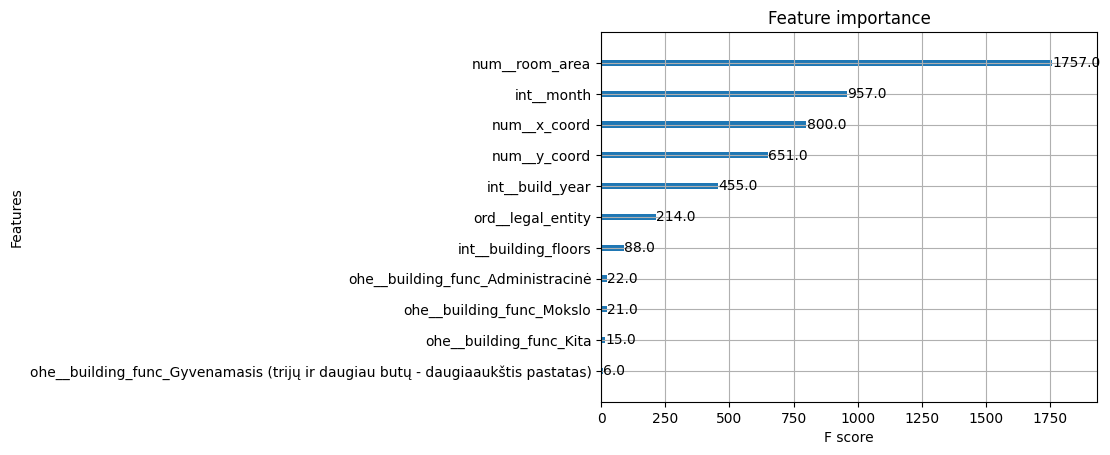

In [ ]:
import xgboost as xgb
xgb.plot_importance(xgb_model)

# 5. Hyperparameter optimization using Optuna

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train_proc, label=y_train)
dvalid = xgb.DMatrix(data=X_valid_proc, label=y_valid)
dtest = xgb.DMatrix(data=X_test_proc, label=y_test)
dtrainvalid = xgb.DMatrix(data=X_validtrain_proc, label=y_validtrain)

In [ ]:
metric = 'rmse'
base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
    'device':'cuda'
}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label()
    y_pred = model.predict(dmat)
    return mean_squared_error(y_true, y_pred, squared=False)

def score_model_mae(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label()
    y_pred = model.predict(dmat)
    return mean_absolute_error(y_true, y_pred)

In [ ]:
import time
learning_rate = 0.03

params = {
    'tree_method': 'approx',
    'learning_rate': learning_rate
}
params.update(base_params)
tic = time.time()
model = xgb.train(params=params, dtrain=dtrain,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  num_boost_round=10000,
                  early_stopping_rounds=50,
                  verbose_eval=1)
print(f'{time.time() - tic:.1f} seconds')

[0]	train-rmse:3.68773	valid-rmse:2.98061
[1]	train-rmse:3.64583	valid-rmse:2.95360
[2]	train-rmse:3.60592	valid-rmse:2.92815
[3]	train-rmse:3.56791	valid-rmse:2.90418
[4]	train-rmse:3.53173	valid-rmse:2.88162
[5]	train-rmse:3.49732	valid-rmse:2.86041
[6]	train-rmse:3.46458	valid-rmse:2.84049
[7]	train-rmse:3.43426	valid-rmse:2.82218
[8]	train-rmse:3.40543	valid-rmse:2.80757
[9]	train-rmse:3.37803	valid-rmse:2.79362
[10]	train-rmse:3.35105	valid-rmse:2.78022
[11]	train-rmse:3.32626	valid-rmse:2.76576
[12]	train-rmse:3.30184	valid-rmse:2.75407
[13]	train-rmse:3.27942	valid-rmse:2.74349
[14]	train-rmse:3.25732	valid-rmse:2.73132
[15]	train-rmse:3.23259	valid-rmse:2.71839
[16]	train-rmse:3.21341	valid-rmse:2.70807
[17]	train-rmse:3.19523	valid-rmse:2.69846
[18]	train-rmse:3.17800	valid-rmse:2.68948
[19]	train-rmse:3.16158	valid-rmse:2.68125
[20]	train-rmse:3.14602	valid-rmse:2.67341
[21]	train-rmse:3.13125	valid-rmse:2.66610
[22]	train-rmse:3.11725	valid-rmse:2.65934
[23]	train-rmse:3.103

In [ ]:
import optuna
def objective(trial):
    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'valid-{metric}')
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0,
                      callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
tic = time.time()
while time.time() - tic < 600:
    study.optimize(objective, n_trials=1)

[I 2025-02-25 14:49:26,408] A new study created in memory with name: no-name-2d628556-8ae5-48ac-b16b-deab78fcaf9b
[I 2025-02-25 14:50:28,976] Trial 0 finished with value: 2.3681637495956362 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226}. Best is trial 0 with value: 2.3681637495956362.
[I 2025-02-25 14:50:35,146] Trial 1 finished with value: 2.300416635282377 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9729188669457949, 'colsample_bynode': 0.8491983767203796, 'reg_lambda': 0.008587261143813469}. Best is trial 1 with value: 2.300416635282377.
[I 2025-02-25 14:50:52,160] Trial 2 finished with value: 2.3493777090393344 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 132, 'subsample': 0.48875051677790415, 'colsample_bynode': 0.36210622617823773, 'reg_lambda': 0.4907861

In [ ]:
print('Stage 1 ==============================')
print(f'best score = {study.best_trial.value}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {learning_rate}')
print(f'best boosting round: {study.best_trial.user_attrs["best_iteration"]}')
print('best tree params --------------------------')
for k, v in study.best_trial.params.items():
    print(k, ':', v)

Stage 1 ==============================
best score = 2.2790315729703976
boosting params ---------------------------
fixed learning rate: 0.03
best boosting round: 65
best tree params --------------------------
tree_method : approx
max_depth : 12
min_child_weight : 13
subsample : 0.9627222317618612
colsample_bynode : 0.7473745682668751
reg_lambda : 0.003141052528668169


In [ ]:
print(study.best_trial.params)

{'tree_method': 'approx', 'max_depth': 12, 'min_child_weight': 13, 'subsample': 0.9627222317618612, 'colsample_bynode': 0.7473745682668751, 'reg_lambda': 0.003141052528668169}


{'tree_method': 'approx', 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7124459860207996, 'colsample_bynode': 0.9858007775023212, 'reg_lambda': 0.0017594606079817886}

In [ ]:
best_params = {'tree_method': 'approx', 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7124459860207996, 'colsample_bynode': 0.9858007775023212, 'reg_lambda': 0.0017594606079817886}

In [ ]:
# Hot water
# best_params = {'tree_method': 'approx', 'max_depth': 12, 'min_child_weight': 13, 'subsample': 0.9627222317618612, 'colsample_bynode': 0.7473745682668751, 'reg_lambda': 0.003141052528668169}

In [ ]:
low_learning_rate = 0.005

params = {}
params.update(base_params)
params.update(best_params)
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain,
                         num_boost_round=10000,
                         evals=[(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=50,
                         verbose_eval=1)

[0]	train-rmse:3.72150	valid-rmse:3.00170
[1]	train-rmse:3.71133	valid-rmse:2.99418
[2]	train-rmse:3.70134	valid-rmse:2.98686
[3]	train-rmse:3.69126	valid-rmse:2.97939
[4]	train-rmse:3.68116	valid-rmse:2.97204
[5]	train-rmse:3.67179	valid-rmse:2.96501
[6]	train-rmse:3.66199	valid-rmse:2.95774
[7]	train-rmse:3.65226	valid-rmse:2.95068
[8]	train-rmse:3.64251	valid-rmse:2.94355
[9]	train-rmse:3.63265	valid-rmse:2.93637
[10]	train-rmse:3.62322	valid-rmse:2.92945
[11]	train-rmse:3.61391	valid-rmse:2.92275
[12]	train-rmse:3.60458	valid-rmse:2.91600
[13]	train-rmse:3.59515	valid-rmse:2.90907
[14]	train-rmse:3.58576	valid-rmse:2.90220
[15]	train-rmse:3.57638	valid-rmse:2.89536
[16]	train-rmse:3.56768	valid-rmse:2.88904
[17]	train-rmse:3.55872	valid-rmse:2.88247
[18]	train-rmse:3.54992	valid-rmse:2.87620
[19]	train-rmse:3.54121	valid-rmse:2.87000
[20]	train-rmse:3.53239	valid-rmse:2.86370
[21]	train-rmse:3.52357	valid-rmse:2.85736
[22]	train-rmse:3.51522	valid-rmse:2.85126
[23]	train-rmse:3.506

In [ ]:
model_stage2.best_iteration

374

In [ ]:
model_final = xgb.train(params=params, dtrain=dtrainvalid,
                        num_boost_round=374,
                        verbose_eval=0)

In [ ]:
print(f"MSE: {score_model(model_final, dtest)}")
print(f"MAE: {score_model_mae(model_final, dtest)}")

MSE: 2.702787399291992
MAE: 1.0894373655319214


In [ ]:
params

{'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'device': 'cuda',
 'tree_method': 'approx',
 'max_depth': 12,
 'min_child_weight': 13,
 'subsample': 0.9627222317618612,
 'colsample_bynode': 0.7473745682668751,
 'reg_lambda': 0.003141052528668169,
 'learning_rate': 0.005}

In [ ]:
scikit_params_wat = {'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'device': 'cuda',
 'tree_method': 'approx',
 'max_depth': 12,
 'min_child_weight': 13,
 'subsample': 0.9627222317618612,
 'colsample_bynode': 0.7473745682668751,
 'reg_lambda': 0.003141052528668169,
 'learning_rate': 0.005,
 'n_estimators': 374}

In [ ]:
scikit_params = {'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'device': 'cuda',
 'tree_method': 'approx',
 'max_depth': 12,
 'min_child_weight': 1,
 'subsample': 0.7124459860207996,
 'colsample_bynode': 0.9858007775023212,
 'reg_lambda': 0.0017594606079817886,
 'learning_rate': 0.01,
 'n_estimators': 551}

In [ ]:
from xgboost import XGBRegressor

sk_model = XGBRegressor(**scikit_params)
sk_model.fit(X_validtrain_proc, y_validtrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.7473745682668751,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=13, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=374, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
preds = sk_model.predict(X_test_proc)
print(mean_squared_error(y_test, preds, squared=False))
print(mean_absolute_error(y_test, preds))

2.7027874350969183
1.0894373090832286


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:48:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i in range(1, 20, 1):
    y_test_proc = y_test.reset_index(drop=True)
    indices = (y_test_proc < i) & (y_test_proc > i-1)
    y_test_proc = y_test_proc[indices]
    X_tests_proc = X_test_proc[indices]
    y_preds = xgb_model.predict(X_tests_proc)
    y_preds_ft = sk_model.predict(X_tests_proc)
    mae = mean_absolute_error(y_test_proc, y_preds)
    mae_ft = mean_absolute_error(y_test_proc, y_preds_ft)
    diff = mae_ft - mae
    print(f"MAE of {i-1} to {i} is {mean_absolute_error(y_test_proc, y_preds_ft)}, fine tuned gains: {diff}, sample size: {len(y_test_proc)}")

MAE of 0 to 1 is 1.4198814377998425, fine tuned gains: 0.035851109926849256, sample size: 10894
MAE of 1 to 2 is 0.5553137189875248, fine tuned gains: -0.001643566045162137, sample size: 6496
MAE of 2 to 3 is 0.4879657649138576, fine tuned gains: -0.04270533352302869, sample size: 3040
MAE of 3 to 4 is 1.2839580995421085, fine tuned gains: 0.008002675764933409, sample size: 1266
MAE of 4 to 5 is 2.230242129643979, fine tuned gains: 0.019761323290286015, sample size: 575
MAE of 5 to 6 is 3.173921971084422, fine tuned gains: 0.06898964221423531, sample size: 309
MAE of 6 to 7 is 4.133864474699974, fine tuned gains: 0.06853875605499038, sample size: 136
MAE of 7 to 8 is 5.058402753090887, fine tuned gains: 0.07566641909735594, sample size: 70
MAE of 8 to 9 is 6.069601343784333, fine tuned gains: 0.03649891614913958, sample size: 50
MAE of 9 to 10 is 7.3068400919908525, fine tuned gains: -0.06610992550849915, sample size: 40
MAE of 10 to 11 is 8.032257514198621, fine tuned gains: 0.1564124

In [ ]:
test_sample = y_test.reset_index(drop=True).sample(15)
sample_idxs = test_sample.reset_index()["index"]
samp_preds = sk_model.predict(X_test_proc.iloc[sample_idxs])
print(f"Average error in sample: {np.mean(abs(test_sample-samp_preds))}")
pd.DataFrame({"Preds": samp_preds, "Actual": test_sample, "Diff":abs(test_sample-samp_preds)})

Average error in sample: 1.021769111951192


,Preds,Actual,Diff
9543,2.408954,1.00,1.408954
63719,2.296741,4.00,1.703259
63740,2.109317,2.00,0.109317
44138,1.845448,3.00,1.154552
65481,1.596834,1.00,0.596834
60695,1.860356,3.00,1.139644
16385,2.059521,2.92,0.860479
20286,2.243443,4.00,1.756557
88135,2.610274,1.00,1.610274
33501,2.247221,0.80,1.447221


# 6. Conclusion

The result is actually very great, RMSE OF about 800 and MAE of 140 across the entire dataset and an MAE of 90 for most samples, meaning the model is wrong by about 90 kWh on average, hopefully still useful